In [5]:
import numpy as np 
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
plt.rcParams["figure.figsize"] = (15,5)

def Derivative_Phi (z):
  if linear :
    return np.array([  [2*z[0,0], 0, 0], 
                      [z[1,0], z[0,0], 0],
                      [z[2,0], 0, z[0,0]],
                      [0, 2*z[1,0], 0],
                      [0, z[2,0], z[1,0]],
                      [0, 0, 2*z[2,0]]     ])

  else :
    return np.array([ [2*z[0,0]  ,       0   ],
                        [ z[1,0]   ,   z[0,0]  ],
                        [   0      ,  2*z[1,0] ]  ]) 
  

def actor_NN (r, g, derivativePhi, w2):
    return - 0.5 * (np.linalg.pinv(r) @ g.T @ derivativePhi.T @ w2)

def Q (z):
    return  z.T @ z 
    
def F (z):
  if linear :
    return np.array([[-1.01887, 0.90506, -0.00215], 
                    [0.82225, -1.07741, -0.17555],
                    [0, 0, -1]                  ])    @  z

  else :
    return np.array([[- z[0,0] + z[1,0]] , 
                    [ -0.5*z[0,0] - 0.5*z[1,0]*(1 -(np.cos(2*z[0,0])+2)**2)]]) 

def G (z):
  if linear :
    return np.array([[0],[0],[1]])
    
  else :
    return np.array([[0],
                     [(np.cos(2*z[0,0]) +2)]])

def updateSystem (z, u, g , k , d):
    dZ = F(z) + g @ u #+ k @ d 
    # print("Fz = \n",F(z))
    # print("dz = \n",dZ)
    return z+dZ , dZ       
  
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def makeF1F2 (ms, d1, w1, m):
  temp = d1 @ w1 @ m.T
  cof1 = - (1/(8*ms)) * d1 @ w1
  cof2 = - (1/8) * (temp + temp.T) 

  f1 = np.zeros(cof1.shape)
  f2 = np.zeros(cof2.shape)

  for i in range(f1.shape[0]):
    for j in range(f1.shape[1]):
      if cof1 [i][j] > 0 : 
        f1 [i][j] = - 2 * cof1 [i][j]
      else : f1 [i][j] = - 0.001

  cof1 += 0.5 * f1

  for i in range(f2.shape[0]):
    for j in range(f2.shape[1]):
      if cof2 [i][j] < 0 :
        f2 [i][j] = - cof2 [i][j]
      else : f2 [i][j] = 0.001
  
  cof2 += f2 

  for ii in range(f2.shape[0]):
    f2 [ii][ii] = np.abs(cof1[ii]) + np.sum(np.abs(cof2[ii])) + 10

  return -f1, f2

In [8]:
linear = False

if linear :
  z = np.array([[1],
               [-1],
               [ 1]], dtype = np.float)
else :
  z = np.random.random((2, 1)) 
  # z = np.ones((2,1))

g = G(z)
print("\nZ :\n",z, "\n")


Z :
 [[0.73699936]
 [0.64502802]] 



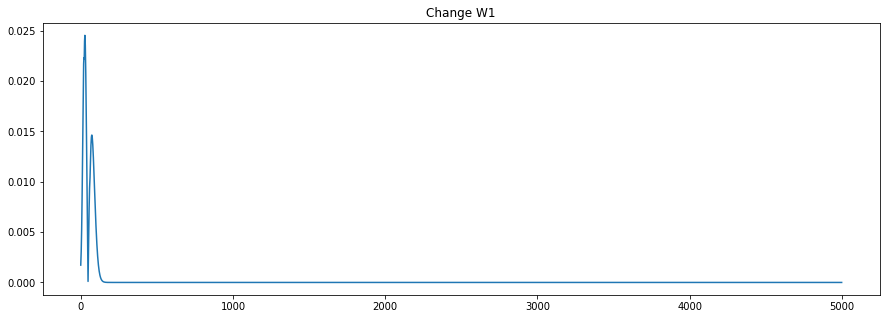

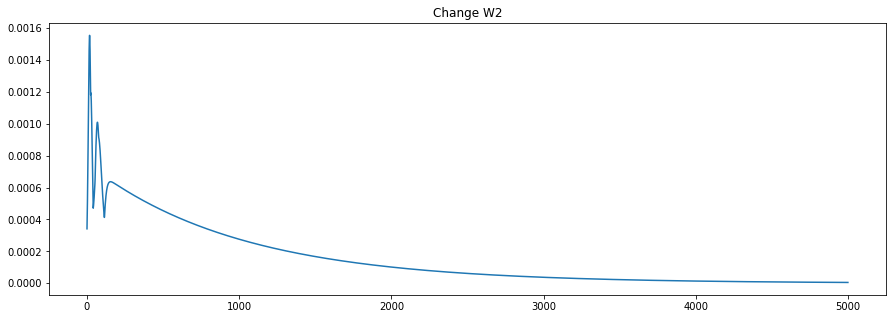

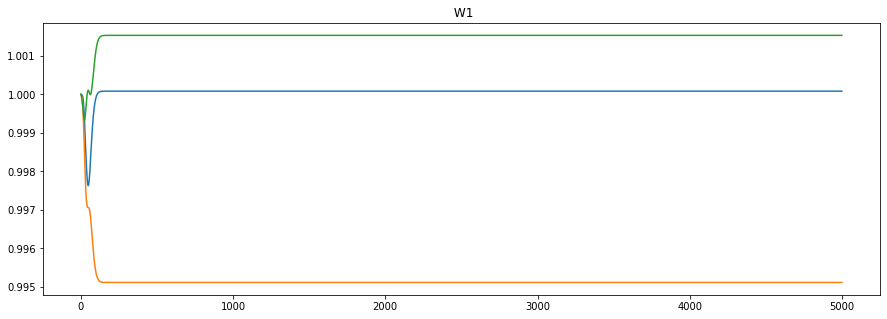

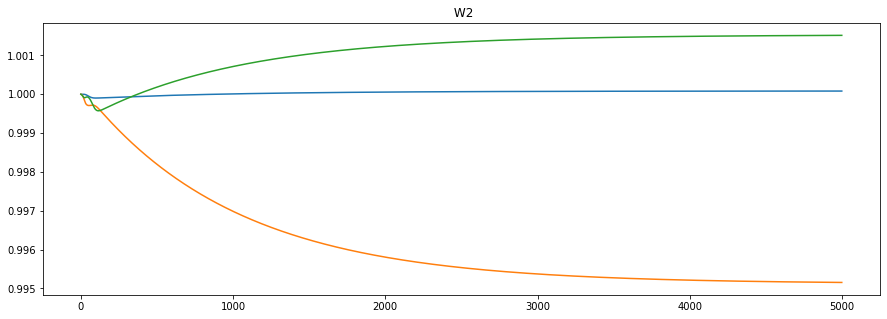

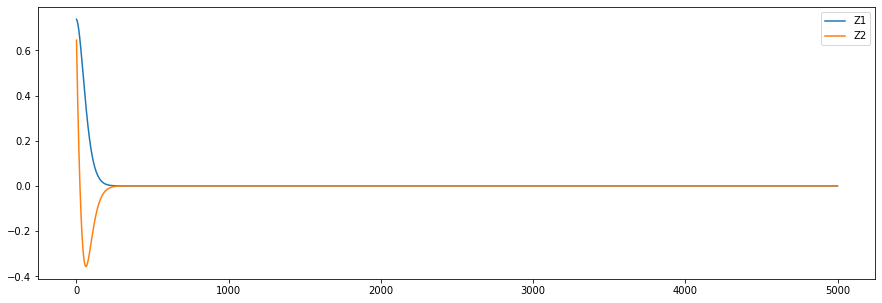

In [9]:
totalIter = 5000
alpha1 = 0.1  ; alpha2 =  (1/10)*alpha1 ; alpha3 = alpha2
gamma = 5
timeScale = 100
R = np.ones((1,1)) 

if linear :
  k = np.array([[1],[0],[0]]) 
else : 
  k = np.array([[1],[0]]) 
  # k = np.array([g[1],g[0]])

if linear : 
  W1 = np.ones((6,1)) #np.random.random((6,1))     # Weight Critic NN
  W2 = np.ones((6,1)) #np.random.random ((6,1))                    # Weight Actor(s) NN
  W3 = np.ones((6,1)) #np.random.random ((6,1))          
else : 
  W1 = np.ones((3,1)) #np.random.random((3,1))     # Weight Critic NN
  W2 = np.ones((3,1)) #np.random.random ((3,1))                    # Weight Actor(s) NN
  W3 = np.ones((3,1)) #np.random.random ((6,1))      

changeW1 = []  ;  changeW2 = [] ; all_Z = [] ; all_W1 = [] ; all_W2 = []

# if linear : 
#   theM = np.zeros((6,6))
#   for i in range(2) :
#       theM [i,i] = 0.8
#   theM [2,2] = 1 
# else :
#   theM = np.zeros((10,10))
#   for i in range(3) :
#       theM [i,i] = 0.8
#   theM [3,3] = 1 

for iter in range (totalIter) :
  
  t = iter / timeScale
  all_W1 . append(W1.flatten())
  all_W2 .append(W2.flatten())
  all_Z.append(z.copy()) 

  dPhi = Derivative_Phi (z)
  actor = actor_NN(R, g, dPhi, W2) 
  d =  0.5 * (1/gamma**2) * k.T @ dPhi.T @ W3
  # print("\nat iter {}  \nz = \n{}  \nu = {} \nd = {}".format(t,z,actor,d))
  _ , dz = updateSystem(z, actor, g, k, d)
  sigma2 =  dPhi @ dz
  normsigma2 = sigma2.T @ sigma2 + 1 
  sigma2bar = sigma2 / normsigma2   
  D1bar =                dPhi @ g  @ g.T @ dPhi.T
  E1bar = (1/gamma**2) * dPhi @ k  @ k.T @ dPhi.T
  ms = normsigma2 
  m = sigma2 /  normsigma2 **2

  # np.array([[0.5017],[-0.0020],[1.0008]])
  # np.array([[1.4245],[1.1682],[-0.1352],[1.4349],[-0.1501],[0.4329]])
  # F1 , F2 = makeF1F2(ms, D1bar, W1 , m)  
  if linear :
    F2 = np.identity(6) * 10
  else : 
    F2 = np.identity(3) * 10


  # term1 = -0.5 * F1 - (1/(8*ms)) * (D1bar@W1)  
  # temp = D1bar @ W1 @ m.T
  # term2 = F2 - (1/8) * (temp.T + temp)

  # ## for non linear example 
  # theM [2,3:] = term1.T 
  # theM [-3:,2] = term1.flatten() 
  # theM [-3: , -3:] = term2 

  # # for linear example 
  # theM [3,4:] = term1.T 
  # theM [-6:,3] = term1.flatten() 
  # theM [-6: , -6:] = term2 

  # np.linalg.cholesky(theM)   # check if F1 and F2 made the M Positive Definite

  W1Change = - alpha1 * (sigma2 / normsigma2 **2) * (sigma2.T @ W1 + Q(z) + actor.T @ R @ actor ) #- gamma**2 * d @ d.T)
  W2Change = - alpha2 * ((F2 @ W2 - F2 @ W1) - (0.25 * D1bar @ W2 @ m.T @ W1)) #F1 @ sigma2bar.T 
  W3change = - alpha3 * ((F2 @ W3 - F2 @ W1) + (0.25 * E1bar @ W3 @ m.T @ W1)) #F1 @ sigma2bar.T 
  changeW1.append(W1Change)  ; changeW2.append(W2Change)

  W1 += W1Change / timeScale
  W2 += W2Change / timeScale
  W3 += W3change / timeScale

  # if iter <= 0.75 * totalIter :
  #   if linear :
  #     actor =((actor)+np.exp(-0.007*t)*37*(np.sin(t)**2*np.cos(t)+np.sin(2*t)**2*np.cos(0.1*t)+np.sin(-1.2*t)**2*np.cos(0.5*t)+np.sin(t)**5+np.sin(1.12*t)**2+np.cos(2.4*t)*np.sin(2.4*t)**3))
  #   else :
  #     actor = (- (np.cos(2*z[0]) + 2) * z[1]).reshape((-1,1))
 
  _ , dz  = updateSystem(z, actor, g, k, actor) 
  z += dz / timeScale
  g = G (z) 
  # k = np.array([g[1],g[0]])
  

plt.plot(np.arange(totalIter), np.sum(np.abs(np.array(changeW1)), axis=1))
plt.title("Change W1")
plt.show()

plt.plot(np.arange(totalIter), np.sum(np.sum(np.abs(np.array(changeW2)), axis=2),axis=1))
plt.title("Change W2")
plt.show() 

plt.plot(np.arange(totalIter), all_W1)
plt.title(" W1")
plt.show() 

plt.plot(np.arange(totalIter), all_W2)
plt.title(" W2")
plt.show() 

plt.plot(np.arange(len(all_Z)), [all_Z[i][0] for i in range(len(all_Z))], label= "Z1")
plt.plot(np.arange(len(all_Z)), [all_Z[i][1] for i in range(len(all_Z))], label= "Z2")
if linear : 
  plt.plot(np.arange(len(all_Z)), [all_Z[i][2] for i in range(len(all_Z))], label= "Z3")

plt.legend()
plt.show() 

In [10]:
print(W1)
# print()
# print(W2)

[[1.00008327]
 [0.99511825]
 [1.00153167]]
